## Обучаем первую модель на MNIST

План на сегодня: пишем первый пайплайн для обучения

1. Пытаемся понять, какие компоненты нам нужны для обучения любой модели
2. Выясняем, что многое уже есть в Pytorch
3. Собираем наш первый скрипт для обучения на датасете MNIST

### 1. Проектируем пайплайн для обучения модели

### 2. Разбираемся с данными

#### 2.1. Организуем доступ к данным с `torch.utils.data.Dataset`

In [1]:
from typing import Any
import torch
from torch.utils.data import Dataset



class MyDataset(Dataset):
    def __init__(self, n: int) -> None:
        super().__init__()
        self.data = torch.arange(n*3).view((n, 3))
        self.labels = torch.randint(0, 5, size=(n,))

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.data[index], self.labels[index]
    
    def __len__(self) -> int:
        return len(self.data)


dataset = MyDataset(n=10)
print(dataset[0])
print(len(dataset))

(tensor([0, 1, 2]), tensor(4))
10


In [2]:
dataset = MyDataset(10)
for i in range(len(dataset)):
    print(dataset[i])

(tensor([0, 1, 2]), tensor(1))
(tensor([3, 4, 5]), tensor(0))
(tensor([6, 7, 8]), tensor(0))
(tensor([ 9, 10, 11]), tensor(4))
(tensor([12, 13, 14]), tensor(3))
(tensor([15, 16, 17]), tensor(4))
(tensor([18, 19, 20]), tensor(1))
(tensor([21, 22, 23]), tensor(4))
(tensor([24, 25, 26]), tensor(1))
(tensor([27, 28, 29]), tensor(1))


#### 2.2. Пакуем данные в батчи с `torch.utils.data.Dataloader`

In [7]:
from torch.utils.data import DataLoader, WeightedRandomSampler

my_loader = DataLoader(
    dataset=dataset,
    batch_size=4,
    # drop_last=
    # shuffle=False,
)

In [8]:
for i, batch in enumerate(my_loader):
    x, y = batch
    if i == 0:
        print(x)
        print(y)

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])
tensor([1, 0, 0, 4])


In [9]:
next(iter(my_loader))

[tensor([[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11]]),
 tensor([1, 0, 0, 4])]

#### 2.3. Посмотрим на MNIST

- какие атрибуты есть у объекта `torchvision.datasets.MNIST`?
- как выглядит одно наблюдение?

In [10]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    'data', 
    train=True, 
    download=True,    
    transform=transforms.ToTensor(),  # что это?
)
test_dataset = datasets.MNIST(
    'data', 
    train=False, 
    download=True,
    transform=transforms.ToTensor(),
)

In [11]:
isinstance(train_dataset, Dataset)

True

In [12]:
x, y = train_dataset[0]
print(x.shape)
print(y)

torch.Size([1, 28, 28])
5


torch.Size([28, 28])


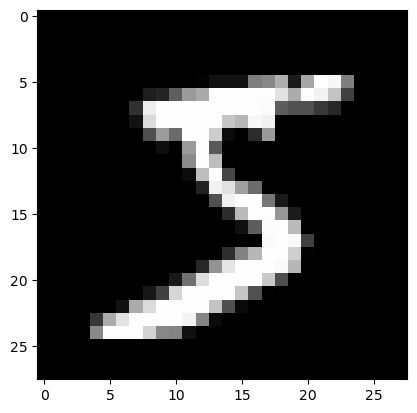

In [15]:
import matplotlib.pyplot as plt
image = x[0]
print(image.shape)
plt.imshow(image, cmap="gray")

Попробуем получить минибатч:

In [17]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Что возвращает `iter()`?

In [18]:
batch: tuple[torch.Tensor, torch.Tensor] = next(iter(train_loader))
x, y = batch
print(x.shape)
print(y.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


Со свёрточными сетями мы познакомимся позже, сейчас же мы будем экспериментировать с обычными полносвязными сетями, но для этого нам нужно будет преобразовать форму батча из `(batch_size, channels, width, height)` в `(batch_size, channels * width * height)`:

In [22]:
batch_size, channels, width, height = x.shape
input_dim = channels * width * height
# x.view((batch_size, -1)).shape
# x.view((-1, input_dim))

x.flatten(1).shape

torch.Size([4, 784])

Ура, с данными вроде разобрались! Теперь разберёмся с моделью

### 3. Реализуем модель с помощью `torch.nn.Module`

Для простоты будем строить небольшую нейронку из двух полносвязных слоёв и `tanh` в качестве функции активации.

Какие параметры должны быть в линейном слое?

In [23]:
hidden_dim = 128
w1 = torch.randn((input_dim, hidden_dim), requires_grad=True)
b1 = torch.randn(hidden_dim, requires_grad=True)

h1 = x.flatten(1) @ w1 + b1
print(h1.grad_fn)
h1.shape

torch.Size([4, 128])

То же самое мы можем сделать с `torch.nn.Linear`:

In [24]:
input_dim = 784
hidden_dim = 128
l1 = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim)
print(l1.weight.shape)
print(l1.bias.shape)

h1 = l1(x.flatten(1))
print(h1.shape)
print(h1.grad_fn)

torch.Size([128, 784])
torch.Size([128])
torch.Size([4, 128])


In [30]:
z = torch.randn(10)
torch.softmax(z, 0)
# zz = torch.exp(z) / torch.exp(z).sum()
# zz.sum()

tensor([0.1370, 0.2554, 0.0175, 0.0270, 0.0048, 0.3373, 0.0587, 0.1115, 0.0430,
        0.0079])

Оказывается, в PyTorch есть огромное множество строительных блоков, из которых можно собирать архитектуры нейросетей. Давайте опишем все компоненты, которые нам нужны

In [31]:
output_dim = 10
hidden_dim = 128
l1 = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim)
l2 = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim)

def forward(x: torch.Tensor) -> torch.Tensor:
    h = l1.forward(x.flatten(1))
    h = torch.nn.functional.tanh(h)
    logits = l2.forward(h)
    probs = torch.nn.functional.softmax(logits, dim=-1)
    return probs

probs = forward(x)
print(probs.shape)
print(probs.grad_fn)
print(probs.sum(dim=1))

torch.Size([4, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


Получается некрасивая ситуация: функция `forward` зависит от глобальных переменных. Мы могли бы передать все параметры через аргументы, но что если их слишком много?



Для создания простых моделей с линейной последовательностью операций можно упаковывать модули в `torch.nn.Sequential`:

In [34]:
sequential_model = torch.nn.Sequential(
    torch.nn.Linear(in_features=input_dim, out_features=hidden_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=hidden_dim, out_features=output_dim),
    # torch.nn.Softmax(dim=-1)
)
sequential_model(x.flatten(1)).shape

torch.Size([4, 10])

Более универсальный способ - спрятать всё внутрь класса-наследника `torch.nn.Module`

In [35]:
class SimpleNet(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.l2 = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.l1.forward(x.flatten(1))
        h = torch.nn.functional.tanh(h)
        logits = self.l2.forward(h)
        return logits
        
        


model = SimpleNet(input_dim, hidden_dim, output_dim)
model(x).shape


torch.Size([4, 10])

Параметры модели:

In [38]:
next(model.named_parameters())

('l1.weight',
 Parameter containing:
 tensor([[-0.0043, -0.0067,  0.0149,  ..., -0.0325,  0.0228, -0.0037],
         [-0.0159, -0.0044, -0.0018,  ...,  0.0154, -0.0197,  0.0326],
         [-0.0075,  0.0259, -0.0269,  ..., -0.0280, -0.0199, -0.0055],
         ...,
         [-0.0156, -0.0144, -0.0128,  ...,  0.0224,  0.0111,  0.0092],
         [-0.0059, -0.0247,  0.0061,  ...,  0.0117, -0.0202, -0.0177],
         [-0.0132, -0.0306,  0.0252,  ...,  0.0192,  0.0331, -0.0272]],
        requires_grad=True))

Вручную обновлять значения стольких параметров очень неудобно. К счастью, за нас это сделает оптимизатор

### 4. Оптимизаторы

In [39]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [66]:
# получим предсказания и посчитаем ошибку
predictions = model.forward(x)
loss = torch.nn.functional.cross_entropy(predictions, y)
print(loss)
# рассчитаем градиенты и обновим параметры
loss.backward()
optimizer.step()

# не забудем почистить градиенты, мы не хотим их накапливать (всегда так?)
optimizer.zero_grad()


tensor(1.0384, grad_fn=<NllLossBackward0>)


### 5. Собираем всё воедино

Опишем, что мы делаем с каждым минибатчем данных:

In [71]:
def training_step(batch: tuple[torch.Tensor, torch.Tensor], model: torch.nn.Module, optimizer: torch.optim.Optimizer) -> tuple[torch.Tensor, torch.Tensor]:
    # прогоняем батч через модель
    x, y = batch
    predictions = model(x)
    # оцениваем значение ошибки
    loss = torch.nn.functional.cross_entropy(predictions, y)
    # обновляем параметры
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # возвращаем значение функции ошибки для логирования
    return loss, predictions

In [72]:
def test_step(batch: tuple[torch.Tensor, torch.Tensor], model: torch.nn.Module) -> tuple[torch.Tensor, torch.Tensor]:
    x, y = batch
    with torch.no_grad():
        predictions = model(x)
        # оцениваем значение ошибки
        loss = torch.nn.functional.cross_entropy(predictions, y)
    return loss, predictions

А теперь: что мы хотим делать в каждой эпохе?

Как насчёт метрик?

In [73]:
def run_epoch(is_train: bool, dataloader: DataLoader, model: torch.nn.Module, optimizer: torch.optim.Optimizer) -> ...:
    loss_values: list[float] = []
    n_correct = 0
    for batch in dataloader:
        if is_train:
            loss, preds = training_step(batch, model, optimizer)
        else:
            loss, preds = test_step(batch, model)
        loss_values.append(loss.item())
        y_hat = preds.argmax(dim=-1)
        _, y = batch
        n_correct += (y == y_hat).sum().item()

    epoch_loss = torch.tensor(loss_values).mean()
    accuracy = n_correct / len(dataloader.dataset)
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")


Создадим модель, оптимизатор и загрузчики данных и запустим обучение:

In [74]:
n_epochs = 10
for i in range(n_epochs):
    print(f"Epoch {i} train:")
    run_epoch(True, train_loader, model, optimizer)
    print(f"Epoch {i} test:")
    run_epoch(False, test_loader, model, optimizer)

Epoch 0 train:
Loss: 0.3769, Accuracy: 0.8957
Epoch 0 test:
Loss: 0.2421, Accuracy: 0.9318
Epoch 1 train:
Loss: 0.2158, Accuracy: 0.9376
Epoch 1 test:
Loss: 0.1799, Accuracy: 0.9481
Epoch 2 train:
Loss: 0.1622, Accuracy: 0.9533
Epoch 2 test:
Loss: 0.1428, Accuracy: 0.9585
Epoch 3 train:
Loss: 0.1302, Accuracy: 0.9623
Epoch 3 test:
Loss: 0.1214, Accuracy: 0.9637
Epoch 4 train:
Loss: 0.1089, Accuracy: 0.9689
Epoch 4 test:
Loss: 0.1083, Accuracy: 0.9676
Epoch 5 train:
Loss: 0.0926, Accuracy: 0.9730
Epoch 5 test:
Loss: 0.1000, Accuracy: 0.9697
Epoch 6 train:
Loss: 0.0801, Accuracy: 0.9768
Epoch 6 test:
Loss: 0.0909, Accuracy: 0.9715
Epoch 7 train:
Loss: 0.0699, Accuracy: 0.9803
Epoch 7 test:
Loss: 0.0896, Accuracy: 0.9728
Epoch 8 train:
Loss: 0.0620, Accuracy: 0.9826
Epoch 8 test:
Loss: 0.0825, Accuracy: 0.9740
Epoch 9 train:
Loss: 0.0553, Accuracy: 0.9849
Epoch 9 test:
Loss: 0.0785, Accuracy: 0.9758
